# Hopfield Networks
### Tom George, UCL

In this tutorial we'll build and train Hopfield networks. By the end we'll have a network which can memorise flags from all 54 African Nations.

Hopfield networks were some of the earliest computational models of memory. A Hopfield network contains many recurrently connected neurons which talk to each other. They store a set of memories $\{ \xi_i^{(n)} \}$ for $n \in [1,N_{\textrm{patterns}}]$ . 

### Import some packages and define some helper functions
Before we start we'll need to import some functions and define some helper functions. You can safely ignore this code.

In [260]:
# RUN THIS CODE (YOU DON'T NEED TO UNDERSTAND IT) 
!pip install numpy matplotlib ipywidgets tqdm wget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import pickle
import copy
import os
import wget 
from tqdm.auto import tqdm
import ipywidgets as widgets
plt.rcParams["animation.html"] = "jshtml"

def plot_patterns(patterns: dict):
    """A function to plot patterns stored in a dictionary, on a grid. 
    Args:
        • patterns (dict): a dictionary of patterns
    Returns:
        • fig, axs (tuple): a tuple of the figure and axes objects
    """
    # just calculate the grid shape 
    N = patterns.__len__() #number of patterns
    grid_size = max(i for i in range(1, int(np.sqrt(N)+1)) if N % i == 0)
    grid_shape = [grid_size,int(N/grid_size)]; grid_shape.sort(); grid_shape = tuple(grid_shape) #calculates the grid shape
    #plots the patterns onto the grid 
    fig, axs = plt.subplots(grid_shape[0],grid_shape[1],figsize=(2*grid_shape[1],2*grid_shape[0]))
    axs = axs.reshape(tuple(grid_shape))
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            name = list(patterns.keys())[i*grid_shape[1]+j]
            pattern = patterns[name]
            im = axs[i,j].imshow(pattern,cmap="Greys_r")
            im.axes.get_xaxis().set_visible(False)
            im.axes.get_yaxis().set_visible(False)
            axs[i,j].set_title(name)
    #makes a colorbar
    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)
    return fig, axs 


def visualise_hopfield_network(HopfieldNetwork, steps_back=0, fig=None, ax=None, title=None):
    """Displays the state of the Hopfield network and a bar chart of similarites to all the stored patterns. 
    Args: 
        • HopfieldNetwork (HopfieldNetwork): the Hopfield network class storing the data to visualise
        • steps_back (int, optional): the number of steps back in the history to visualise. Defaults to 0 i.e. current state.
        • fig, ax: option fig and ax objects to plot onto. If None, new ones are created.
        • title (str, optional): the title of the figure. Defaults to None.
    """

    """Get the data to plot"""
    state = HopfieldNetwork.history['state'][-steps_back-1]
    similarities = HopfieldNetwork.history['similarities'][-steps_back-1]
    pattern_names = HopfieldNetwork.pattern_names
    pattern_shape = HopfieldNetwork.pattern_shape
    N_patterns = HopfieldNetwork.N_patterns

    """Create figure"""
    if ax is None:
        fig = plt.figure(figsize=(16,4))
        ax0 = fig.add_axes([0,0,1/2,0.9])
        ax1 = fig.add_axes([1/2,1/3,0.95/2,0.9-1/3])
        ax = np.array([ax0,ax1])
        
    """Displays the state of the Hopfield network"""
    im = ax[0].imshow(state.reshape(pattern_shape),cmap="Greys_r")

    ax[0].set_title(title or "Network activity pattern", fontweight='bold')
    im.axes.get_xaxis().set_visible(False)
    im.axes.get_yaxis().set_visible(False)

    """Displays the similarity of the Hopfield network state  """
    ax[1].set_title("Similarity to stored patterns")
    bars = ax[1].bar(np.arange(N_patterns),similarities)
    best_pattern_id = np.argmax(np.abs(similarities))
    best_pattern = HopfieldNetwork.patterns_dict[HopfieldNetwork.pattern_names[best_pattern_id]]
    ax[1].set_xticks(np.arange(N_patterns))
    ax[1].set_xticklabels(pattern_names)
    ax[1].tick_params(axis='x', labelrotation = 60)
    ax[1].axhline(0, color='black', lw=1)
    colors = ['C0']*N_patterns
    colors[best_pattern_id]='g'
    ax[1].tick_params(axis='x', which='major', pad=2)
    ax[1].set_ylim(top=1,bottom=-1)
    for i,(bar,tick) in enumerate(zip(bars,ax[1].get_xticklabels())):
        bar.set_facecolor(colors[i])
        tick.set_ha('right')
        if i == best_pattern_id:
            tick.set_color('g')
    
    """Display a small inset of the "best pattern" in the similarity bar chart"""
    width = HopfieldNetwork.N_patterns / 10
    inset_ax = ax[1].inset_axes([best_pattern_id+0.5,0.5-(1-similarities[best_pattern_id]),width,0.4],transform=ax[1].transData)
    best_pattern = HopfieldNetwork.patterns_dict[HopfieldNetwork.pattern_names[best_pattern_id]]
    inset_ax.imshow(best_pattern,cmap="Greys_r")
    plt.setp(inset_ax, xticks=[], yticks=[])
    for spine in list(inset_ax.spines.keys()):
        inset_ax.spines[spine].set_color('g')        
        inset_ax.spines[spine].set_linewidth(2)

    return fig, ax

def animate_hopfield_network(HopfieldNetwork,n_steps=10):
    """Makes an animation of the last n states (drawn from the history) of the Hopfield network
    Args:
        • HopfieldNetwork (HopfieldNetwork): the Hopfield network class storing the data to animate
        • n_steps (int, optional): _description_. Defaults to 10.
    """
    fig,ax = HopfieldNetwork.visualise()
    def animate(i,fig,ax):
        """The function that is called at each step of the animation.
        This just clears the axes and revisualises teh state of the network at the next step."""
        ax[0].clear()
        ax[1].clear()
        steps_back = n_steps - i
        fig,ax = HopfieldNetwork.visualise(steps_back=steps_back,fig=fig,ax=ax)
        fig.suptitle("Step %d"%i)
        # fig.set_tight_layout(True)
        plt.close()
    anim = matplotlib.animation.FuncAnimation(fig,animate,fargs=(fig,ax),frames=n_steps,interval=100,blit=False)
    return anim

## 1 Making random patterns

We'll start off by training a _classical_ (binary) Hopfield network to store 5 patterns. Each patterns will be a 10 x 10 random binary pattern. These will be stored in a dictionary:


Text(0.5, 0.98, 'These are 5 patterns our network will memorize')

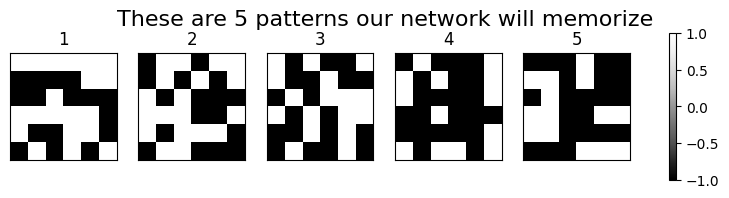

In [251]:
#Create 5 random patterns of size 10x10
N_patterns = 5
pattern_size = (6,6)
random_patterns = {str(i) : np.random.choice([-1,1],size=pattern_size) for i in range(1,N_patterns+1)}

fig, ax = plot_patterns(random_patterns)
fig.suptitle(f"These are {random_patterns.__len__()} patterns our network will memorize", fontsize=16)

## 2 Making a Hopfield Network 

Below we provide some basic code defining a Hopfield Network class. You don't need to understand this but it'll be useful to know what important attributes and functions it contains.

Suppose we initialise a network `HFN = HopfieldNetwork(random_patterns)`

**Important attributes** 

* `HFN.state` is the current state of the network, a vector $s \in \mathbb{R}^{N_{\textrm{neurons}}}$
* `HFN.w` is the synpatic weight matrix. <span style="color:red"> _[TO DO: NOT YET DEFINED]_ </span>
* `HFN.flattened_patterns` is a matrix of stored patterns $\Xi \in \mathbb{R}^{N_{\textrm{Patterns}} \times N_{\textrm{neurons}}}$ such that $\Xi_{n,i} \equiv \xi^{(n)}_{i}$ is the $i^{\textrm{th}}$ element of the $n^{\textrm{th}}$ pattern. 
* `HFN.similarities` is a measure of similarity (a number from 0 to 1) between the current state and all saved patterns, $\textrm{sim} \in \mathbb{R}^{N_{\textrm{patterns}}}$. 
* `HFN.history` is a dictionary containing all past `state` and `similarity` vectors of the network. 

**Important methods**

* `HFN.update_state()`: Takes the current state and updates it $s(t) \leftarrow s(t+1)$. Then, the `state` and `similarities` are saved to history. <span style="color:red"> _[TO DO: NOT YET DEFINED]_ </span> 
* `HFN.set_state(state)`: Sets the state of the network to whatever you pass as `state`. Alternatively pass HFN.set_state(random=True)` to reinitialise. 
* `HFN.visualise()`: Displays the current state of the network next to a bar chart of how similar it is to all the saved patterns. 
* `HFN.animate(n_steps)`: Makes a short video displaying the evolution of the state of the network over the past `n_steps`


Notice some things have been left <span style="color:red"> _[TO DO]_. (these are for you to do!)</span>


In [252]:
class HopfieldNetwork:
    """A (Modern) Hopfield Network"""
    def __init__(self,patterns_dict):
        """Initialises the Hopfield network with a set of patterns. It loads 
        Args: 
            • patterns: a dictionary containing the patterns to be stored in the network labelled by their names. Patterns can be any shape, they will be flattened into vectors during initialisation."""

        # Convert the patterns dictionary into a an array of flattened patterns
        self.patterns_dict = patterns_dict
        self.pattern_names = list(patterns_dict.keys())
        self.patterns = np.array(list((patterns_dict.values())))
        self.pattern_shape = patterns_dict[self.pattern_names[0]].shape
        # Some useful variables
        self.N_neurons = self.patterns[0].size
        self.N_patterns = self.patterns_dict.__len__()
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons) 
        self.flattened_patterns = np.reshape(self.patterns,(self.N_patterns,self.N_neurons)) 

        # Initialises a history dictionary
        self.history = {'state':[],'similarities':[]}  
        
        # Initialise the weights and state of the network
        # =================== YOUR CODE HERE ==============================
        self.w = NotImplemented  # <-- YOU WILL NEED TO WRITE THIS YOURSELF
        # =================================================================
    
        # SOLUTION
        self.w = self.flattened_patterns.T @ self.flattened_patterns 


        self.set_state(random=True) #initialises the state of the network 
    
    def set_state(self, state=None, random=False):
        """Sets the state of the Hopfield network. If random = True, sets state to a random vector"""
        if random: self.state = np.random.choice([-1,1],size=(self.N_neurons,))
        else: self.state = state.reshape(-1)
        self.similarities= self.get_similarities()
        self.save_history()

    def update_state(self):
        """Updates the state of the Hopfield network"""
        raise NotImplementedError

    def save_history(self):
        """Saves the history of the Hopfield network"""
        self.history['state'].append(copy.deepcopy(self.state))
        self.history['similarities'].append(copy.deepcopy(self.similarities))
 
    def get_similarities(self,state=None):
        """Compares the state (defaults to the current state of the network to all stored patterns and returns a measure of similary between the current state and each stored pattern.
        This measure is taken as cos(theta) where theta is the angle between the current state vector and the stored pattern vectorin N-D space.
        """
        state = self.state if state is None else state
        return np.dot(self.flattened_patterns, self.state) / (np.linalg.norm(self.flattened_patterns,axis=1) * np.linalg.norm(self.state))
    

    # =================== PLOTTING FUNCTIONS ==============================
    def visualise(self, steps_back=0, fig=None, ax=None, title=None):
        """Visualises the state of the Hopfield network n_steps back (defaults to steps_back=0, i.e. current state)"""
        fig, ax = visualise_hopfield_network(self, steps_back=steps_back, fig=fig, ax=ax, title=title)
        return fig, ax

    def animate(self,n_steps=10):
        """Animates the last n_steps of the Hopfield network"""
        anim = animate_hopfield_network(self,n_steps=n_steps)
        return anim


### 2.1 Writing the update function
Now lets write the update function. Recall from the lecture the following dynamic update rule:

1. Choose a random neuron, $i$: 
$$ i \sim_{Rand} \{1, 2, ..., N_{\textrm{Neurons}}\} $$ 

2. Update neuron $i$
$$ s_{i}(t + 1) \leftarrow \textrm{sgn} \bigg( \sum_{j}^{N_{\textrm{Neurons}}} w_{ij} s_{j}(t) \bigg) $$

where 

$$ w_{ij} =  \sum_{n=1}^{N_{\textrm{patterns}}} \xi_{i}^{(n)} \xi_{j}^{(n)}$$

1. You will need to go into the above class definition and complete the line
```
        # =================== YOUR CODE HERE ==============================
        self.w = NotImplemented  # <-- YOU WILL NEED TO WRITE THIS YOURSELF
        # ================================================================= 
```
2. Then, complete the following code which implements the update function.


These updates are called _asynchronous_ updates because we only update the value of one neuron at a time. It is possible to do _synchronous_ updates where all neurons are updated simultaneously (Optional) you might like to try write this out in python code too. 

In [9]:
def update_state(self, asynchronous=True):
    """Updates the state of the Hopfield network"""
    # =================== YOUR CODE HERE ==============================
    raise NotImplementedError
    # =================================================================
    
HopfieldNetwork.update_state = update_state

In [253]:
### SOLUTION 1 ###
# w = flattened_patterns.T @ flattened_patterns 

### SOLUTION 2 ###
def update_state(self, asynchronous = True):
    """Updates the state of the Hopfield network and saves to history"""
    #asyncronous updates one neuron at a time
    if asynchronous == True:
        i = np.random.randint(self.N_neurons)
        self.state[i] = np.sign(self.w[i,:] @ self.state)

    #synchronous updates all neurons at once
    elif asynchronous == False:
        self.state = np.sign(self.w @ self.state)
    
    self.similarities= self.get_similarities()
    self.save_history()

HopfieldNetwork.update_state = update_state #set this as the update_state method of the HopfieldNetwork class

## 3. Testing the Hopfield Network

In [292]:
HFN = HopfieldNetwork(random_patterns)

Congratulations! You just built your first Hopfield  Network. Lets test it out. 

First thing we'll try is initialising it _close_ to one of the stored patterns and seeing how it evolves: 

### 3.0 Pattern stability

The learned patterns should be stable fixed points of the system dynamics. 

**Insert sketch of stablity** 

  0%|          | 0/200 [00:00<?, ?it/s]

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'State after 200 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

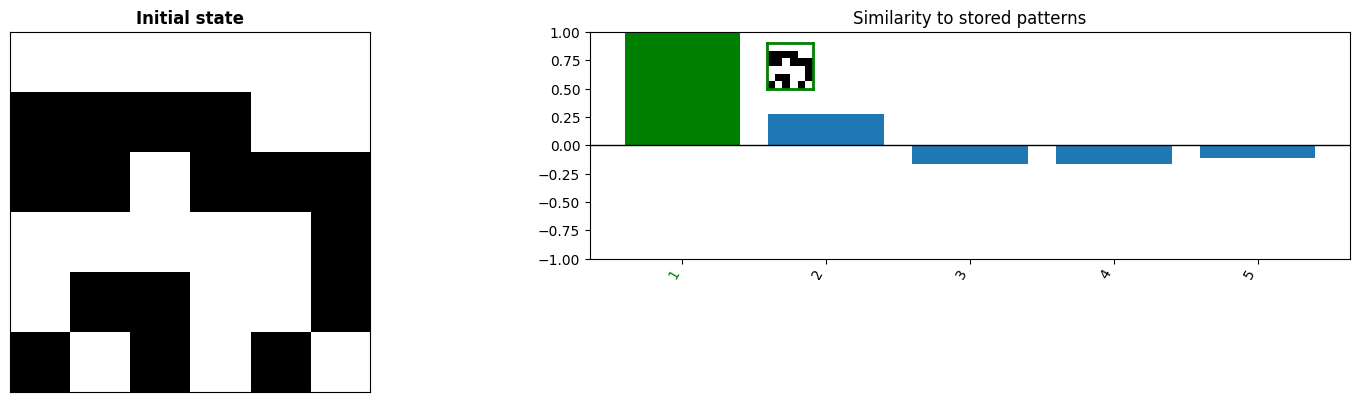

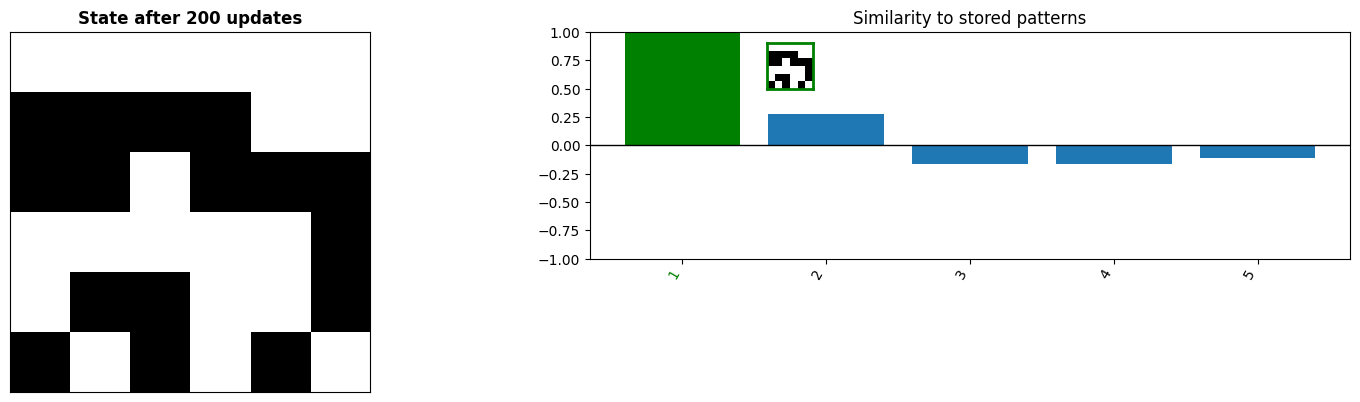

In [294]:
pattern_to_start = '1'

HFN.set_state(random_patterns[pattern_to_start].flatten()) #reinitialise the state of the network
HFN.visualise(title="Initial state")
for i in tqdm(range(200)):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")

### 3.1 Pattern denoising

Better yet...if we start _near_ one of the saved patterns. 
We'll do this by randomly flipping X-% of our bits.

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'State after 200 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

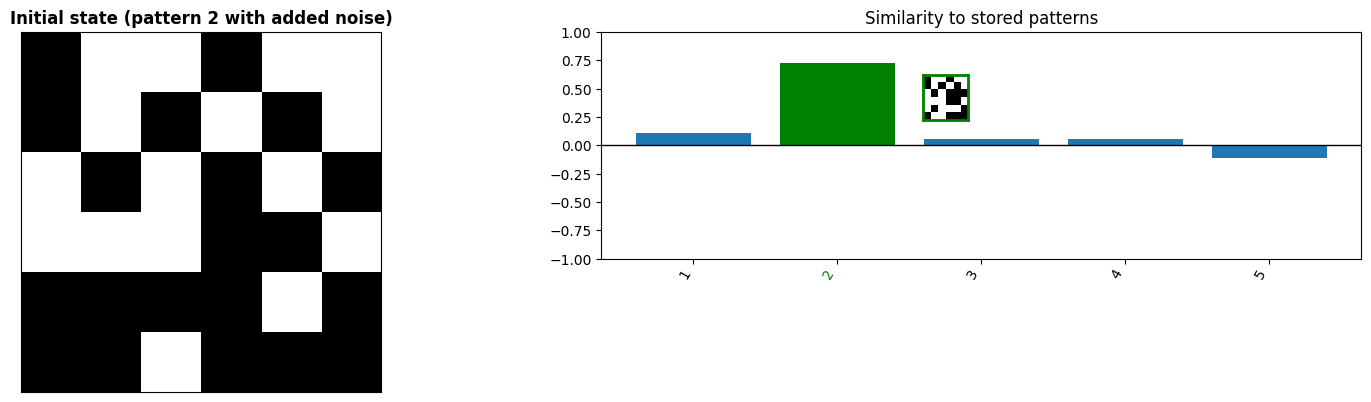

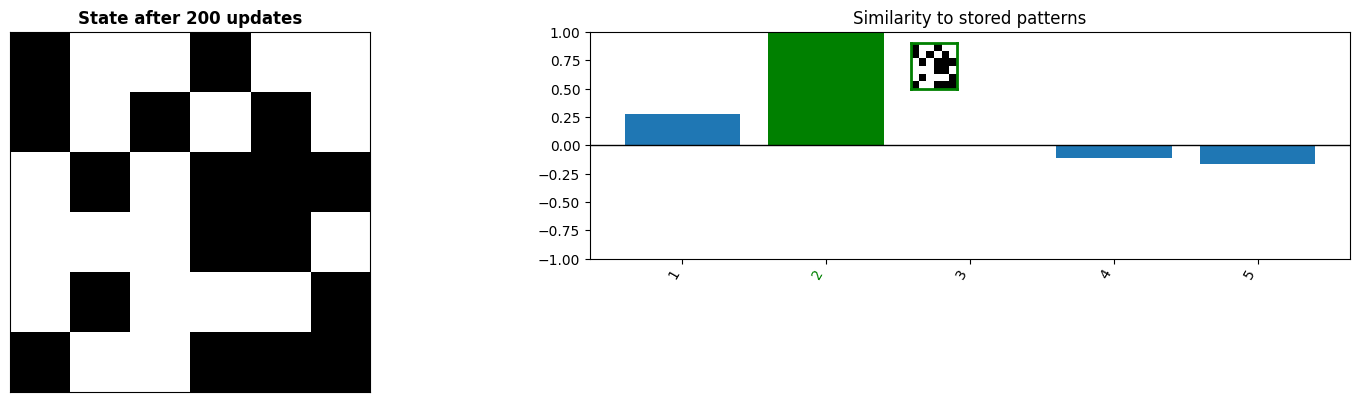

In [295]:
pattern_to_start = '2'
X = 20 # percentage of bits to flip 

noisy_state = random_patterns[pattern_to_start].flatten() * np.random.choice([-1,1],p=[X/100,1-X/100],size=(HFN.N_neurons,))
HFN.set_state(noisy_state) #reinitialise the state of the network
HFN.visualise(title=f"Initial state (pattern {pattern_to_start} with added noise)")
for i in range(200):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")

Has it accurately recovered the pattern we started near? 

### 3.2 Pattern completion
What if we occlude part of a pattern...will the network be able to retrieve the rest? 

In [296]:
def mask_pattern(pattern):
    """Masks all but the top left hand corner of a pattern"""
    mask = np.zeros_like(pattern)
    mask[:pattern.shape[0]//2,:pattern.shape[1]//2] = 1
    return pattern * mask

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'State after 200 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

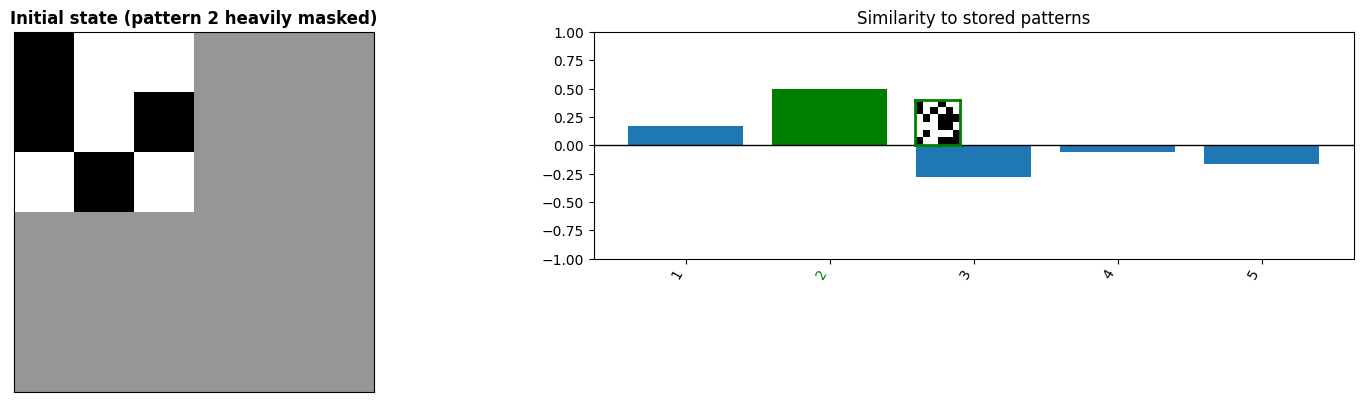

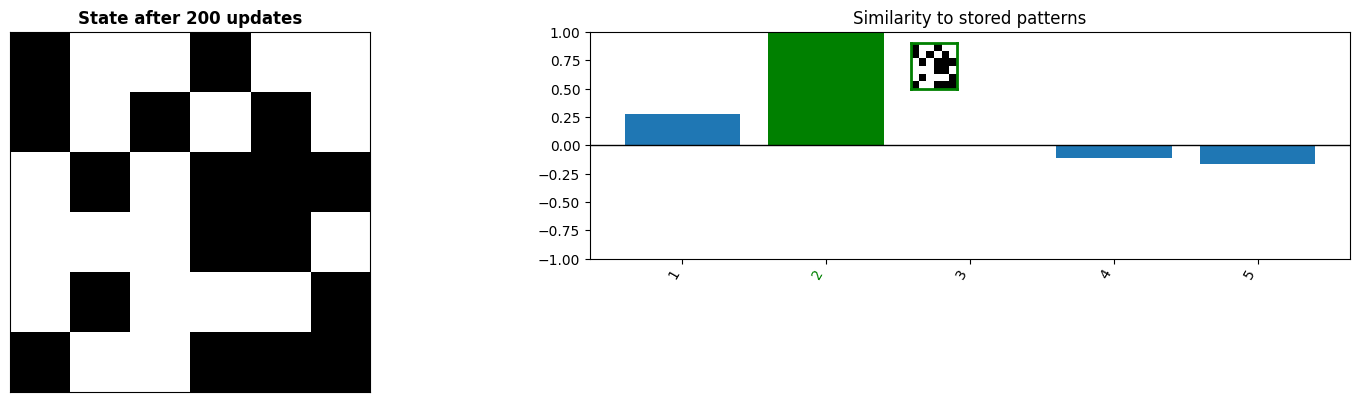

In [298]:
pattern_to_start = '2'  
HFN.set_state(mask_pattern(random_patterns[pattern_to_start]).flatten()) #reinitialise the state of the network
HFN.visualise(title=f"Initial state (pattern {pattern_to_start} heavily masked)")
for i in range(200):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")

### 3.3 Negative patterns

Theory tells us negative patterns should be stable fixed points just like the original patterns. Let's test this. 

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'State after 200 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

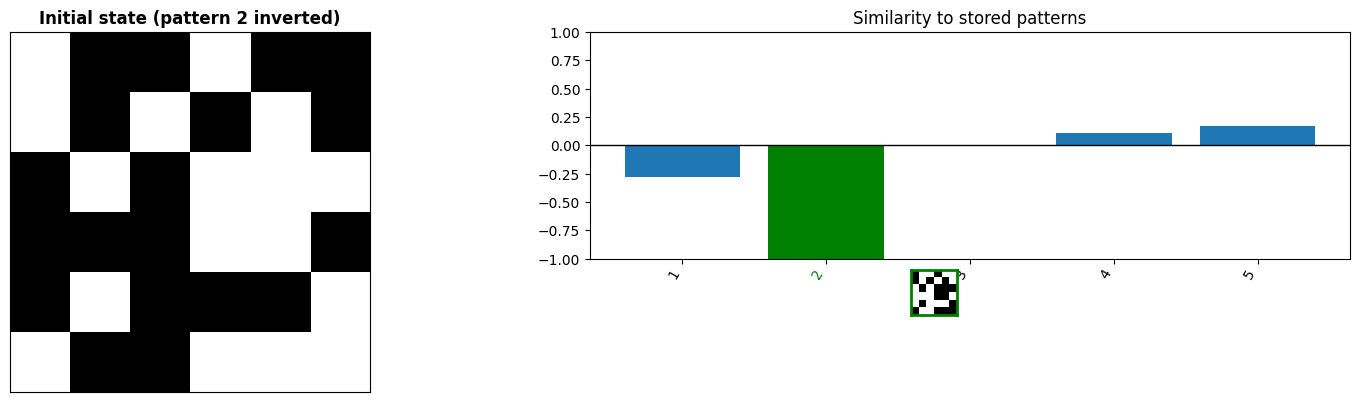

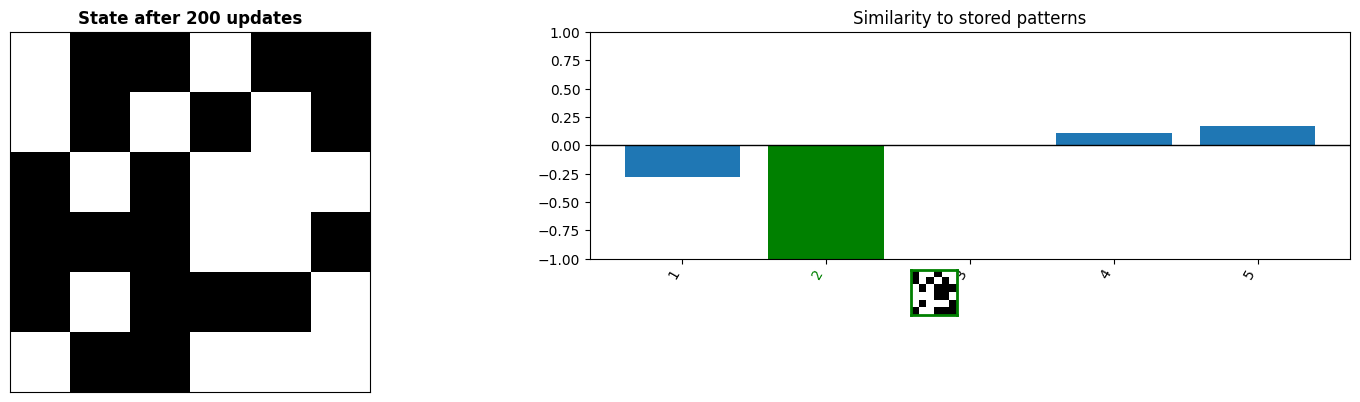

In [301]:
pattern_to_start = '2'  
HFN.set_state(-random_patterns[pattern_to_start].flatten()) #note the negative sign
HFN.visualise(title=f"Initial state (pattern {pattern_to_start} inverted)")
for i in range(200):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")

### 3.4 Mixed states and spurious states

What happens if we try initialise the network in a mixed state. For example and mix of patterns 1, 2 and 3: 

$$ s_i(0) := \xi_i^{\textrm{mix}} = \textrm{sgn} \big( \pm \xi_i^{(1)} \pm \xi_i^{(2)} \pm \xi_i^{(3)} \big)$$

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'State after 200 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

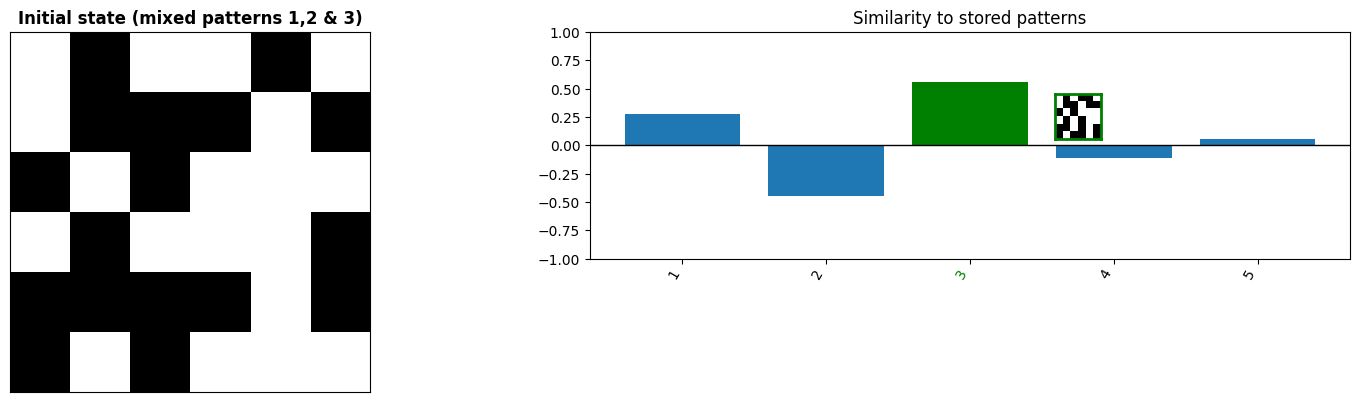

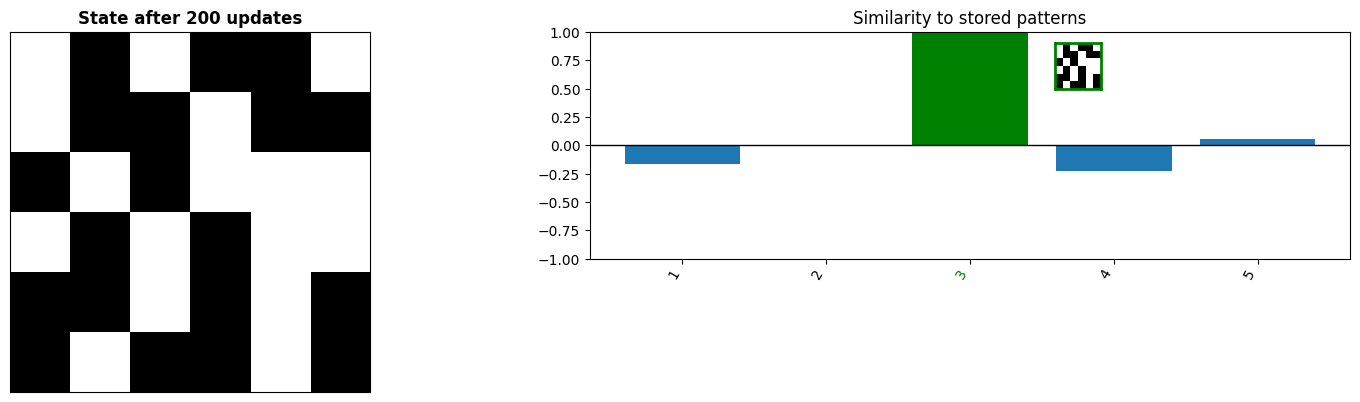

In [303]:
mixed_state = np.sign(random_patterns['1'].flatten() - random_patterns['2'].flatten() + random_patterns['3'].flatten())

HFN.set_state(mixed_state) #reinitialise the state of the network
HFN.visualise(title=f"Initial state (mixed patterns 1,2 & 3)")
for i in range(200):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")

### Strong patterns

We can embed some patterns into the network _more strongly_ than others. 

(<Figure size 1000x400 with 11 Axes>,
 array([[<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>,
         <Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
         <Axes: title={'center': '5'}>],
        [<Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
         <Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
         <Axes: title={'center': '10'}>]], dtype=object))

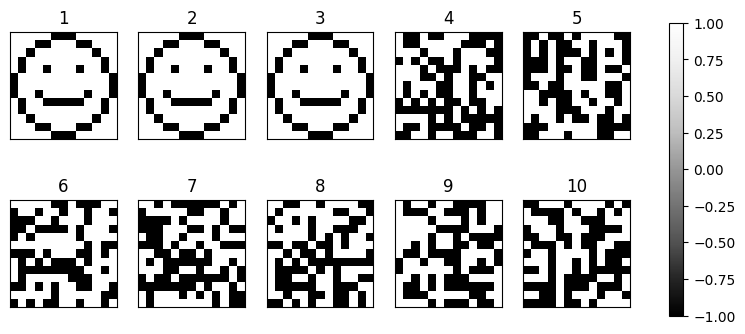

In [333]:
smiley_state = np.array([
    [1,1,1,1,1,0,0,0,1,1,1,1,1],
    [1,1,1,0,0,1,1,1,0,0,1,1,1],
    [1,1,0,1,1,1,1,1,1,1,0,1,1],
    [1,0,1,1,1,1,1,1,1,1,1,0,1],
    [1,0,1,1,0,1,1,1,0,1,1,0,1],
    [0,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,1,1,1,1,1,1,1,1,1,0],
    [0,1,1,0,1,1,1,1,1,0,1,1,0],
    [1,0,1,1,0,0,0,0,0,1,1,0,1],
    [1,0,1,1,1,1,1,1,1,1,1,0,1],
    [1,1,0,1,1,1,1,1,1,1,0,1,1],
    [1,1,1,0,0,1,1,1,0,0,1,1,1],
    [1,1,1,1,1,0,0,0,1,1,1,1,1],
])
random_patterns = {str(i) : np.random.choice([-1,1],size=(13,13)) for i in range(1,10+1)}
random_patterns['1'] = smiley_state
random_patterns['2'] = smiley_state
random_patterns['3'] = smiley_state
plot_patterns(random_patterns)

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'State after 2000 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

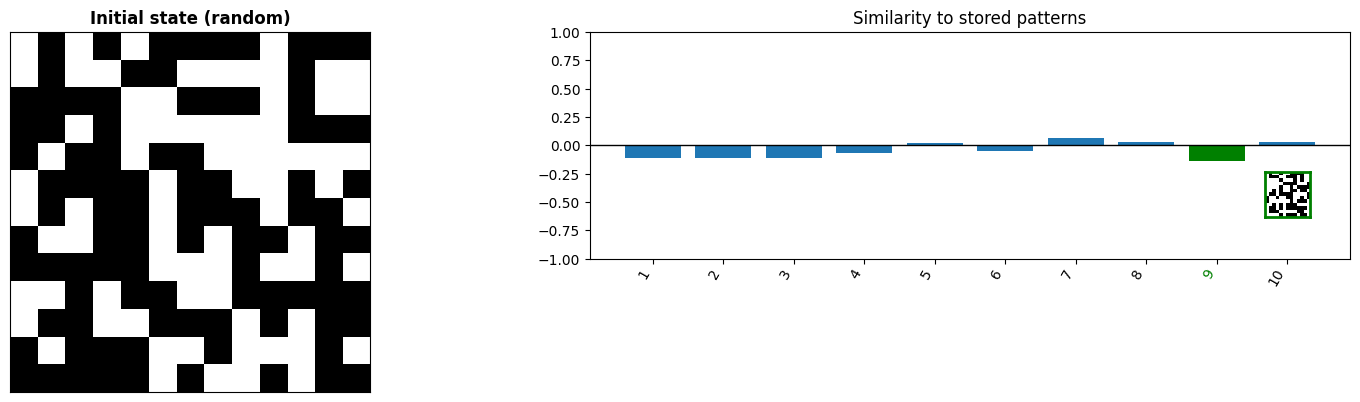

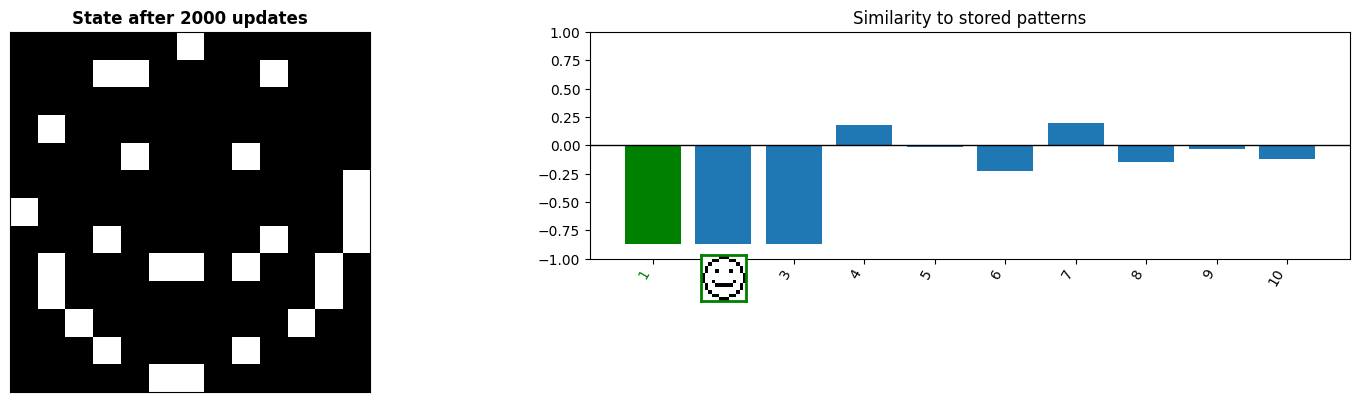

In [338]:
HFN = HopfieldNetwork(random_patterns)
HFN.set_state(random=True) #reinitialise the state of the network
HFN.visualise(title="Initial state (random)")
for i in range(2000):
    HFN.update_state()
HFN.visualise(title=f"State after {i+1} updates")

### 3.5 Testing the memory capacity 

Lets try the same but in a network with more patterns and fewer neurons. By doing so we may demonstrate some of the memory issues suffered by classical Hopfield networks.

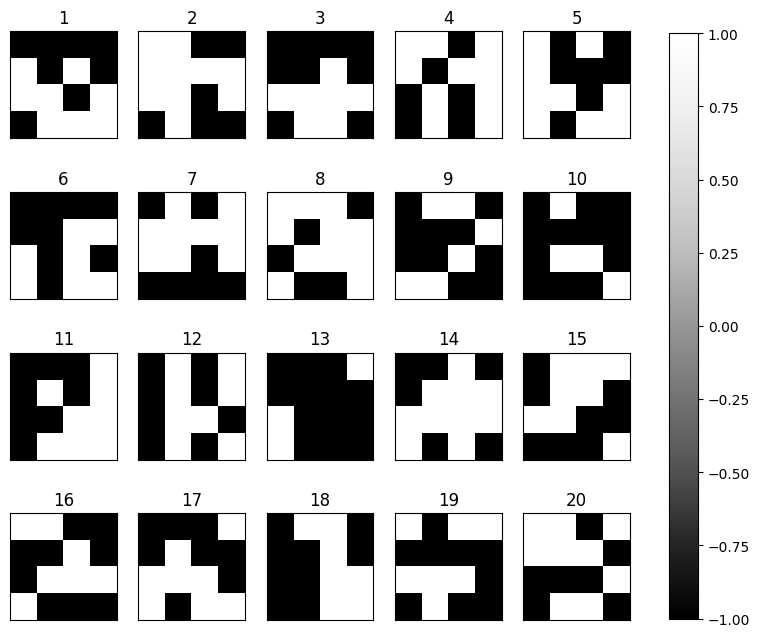

In [284]:
#Create 100 random patterns of size 6x6
N_patterns = 20
pattern_size = (4,4)
random_patterns_many = {str(i) : np.random.choice([-1,1],size=pattern_size) for i in range(1,N_patterns+1)}
fig, ax = plot_patterns(random_patterns_many)

HFN = HopfieldNetwork(random_patterns_many)

Theory has told us that the memory capacity of a Hopfield Network (roughly how many memories we can store before they become unstable) becomes an issue once the number of memories exceeds 13% the number of neurons. 

$$ N_{\textrm{memories}} \sim 0.138 \times N_{\textrm{Neurons}} $$

Here we have 
and for our 4 x 4 patterns there are 16 neurons...so we should expect errors to start piling up one we have more than $0.138 \times 36 \approx 5$ patterns! 

40.0% of the memory patterns are unstable. These are ['2', '4', '5', '6', '7', '11', '13', '20']


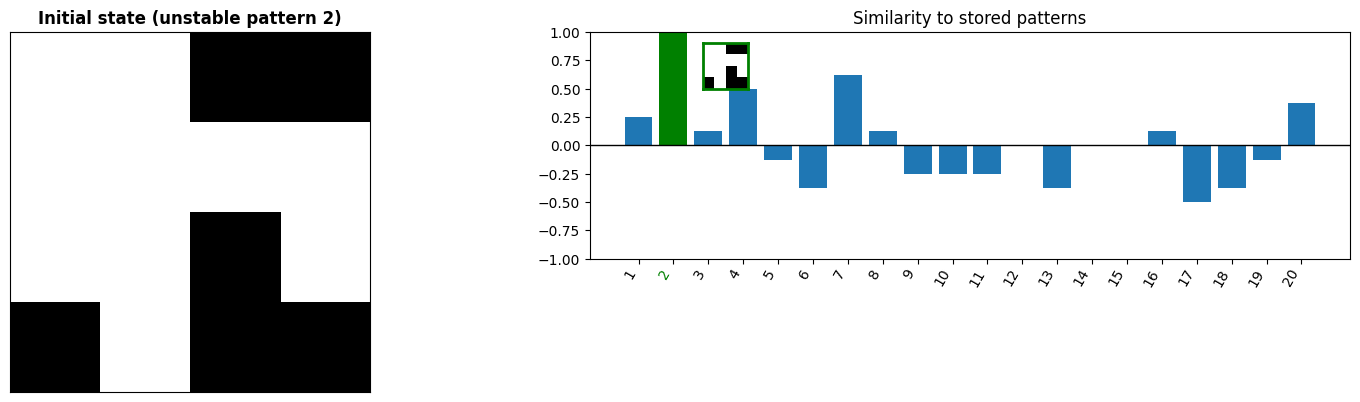

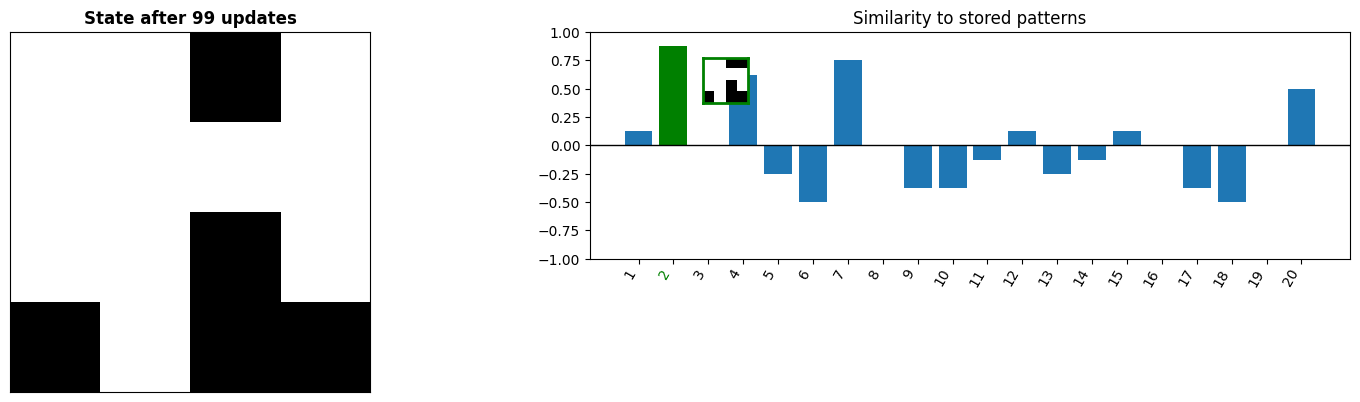

In [289]:
# test ALL the memories and set which ones are unstable
unstable_patterns = []
for pattern in random_patterns_many:
    HFN.set_state(random_patterns_many[pattern].flatten())
    initial_state = copy.deepcopy(HFN.state)
    for i in range(100):
        HFN.update_state(asynchronous=True)
    if not np.all(initial_state == HFN.state): #if a pattern is not stable, add it to the list
        unstable_patterns.append(pattern)

print(f"{100*len(unstable_patterns)/len(random_patterns_many):.1f}% of the memory patterns are unstable. These are {unstable_patterns}")

#visualise an unstable memory
if len(unstable_patterns) > 0:
    HFN.set_state(random_patterns_many[unstable_patterns[0]].flatten()) #reinitialise the state of the network
    HFN.visualise(title=f"Initial state (unstable pattern {unstable_patterns[0]})")
    for i in range(100):
        HFN.update_state()
    HFN.visualise(title=f"State after {i+1} updates")

**Insert sketch of attractor landscape with TOO many memories**

### 3.6 Complex patterns 

Here we've downloaded flags of all 54 African nations and converted them to greyscale.

Flags data successful loaded!


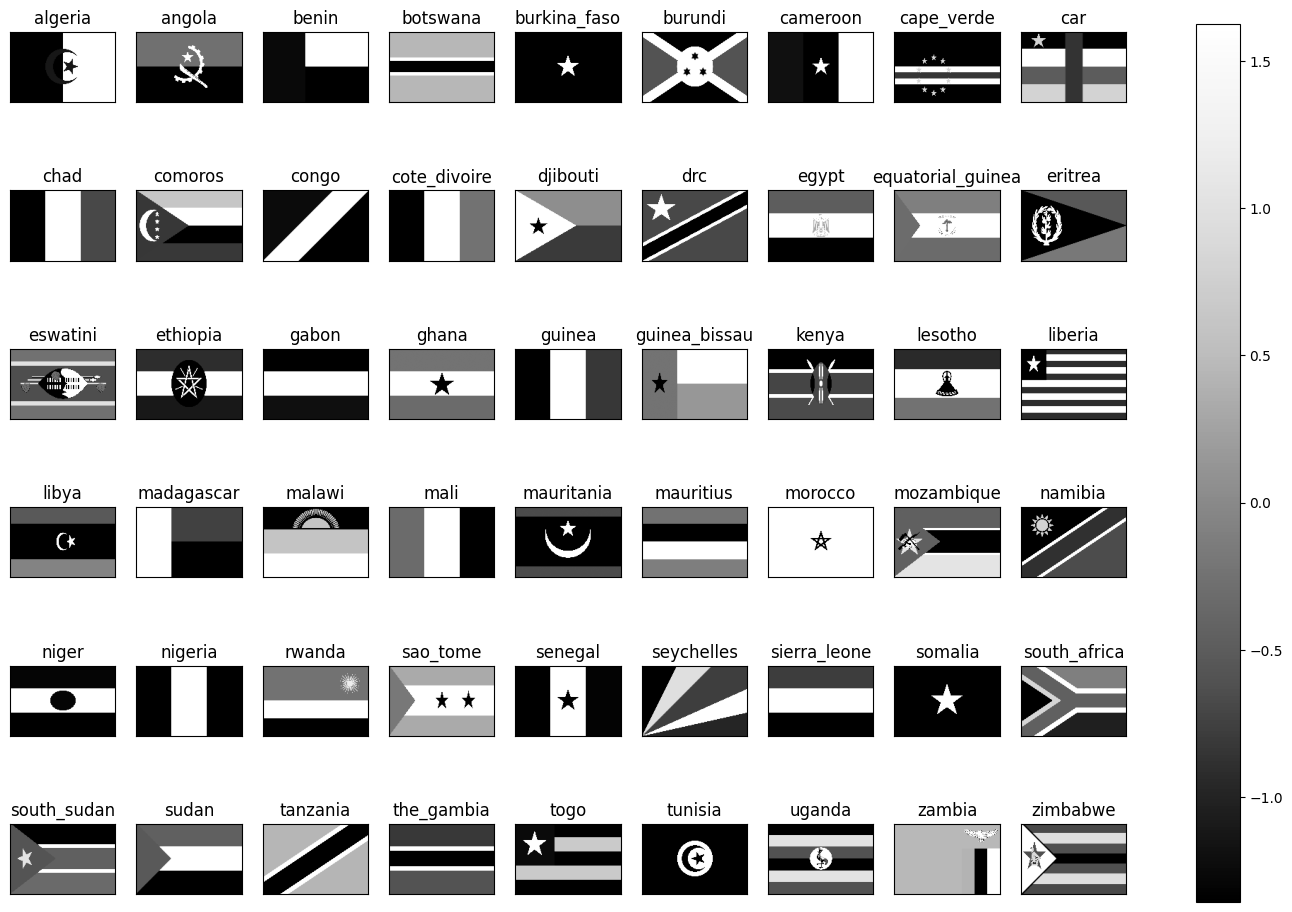

In [38]:
if os.path.exists("flags_of_africa.pickle"):
    pass
else: 
    print("Data not found, trying to download it from github...") 
    import wget
    wget.download("https://github.com/TomGeorge1234/HopfieldNetworkTutorial/raw/main/flags_of_africa.pickle")
flags = pickle.load(open("flags_of_africa.pickle","rb"))
print("Flags data successful loaded!")
fig, ax = plot_patterns(flags)

In [39]:
# Initialise a new Hopfield network with the flags as patterns
HFN_complex = HopfieldNetwork(flags)

  0%|          | 0/10 [00:00<?, ?it/s]

synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating


  0%|          | 0/10 [00:00<?, ?it/s]

synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating


  0%|          | 0/10 [00:00<?, ?it/s]

synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating
synchronously updating


(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'Network activity pattern'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

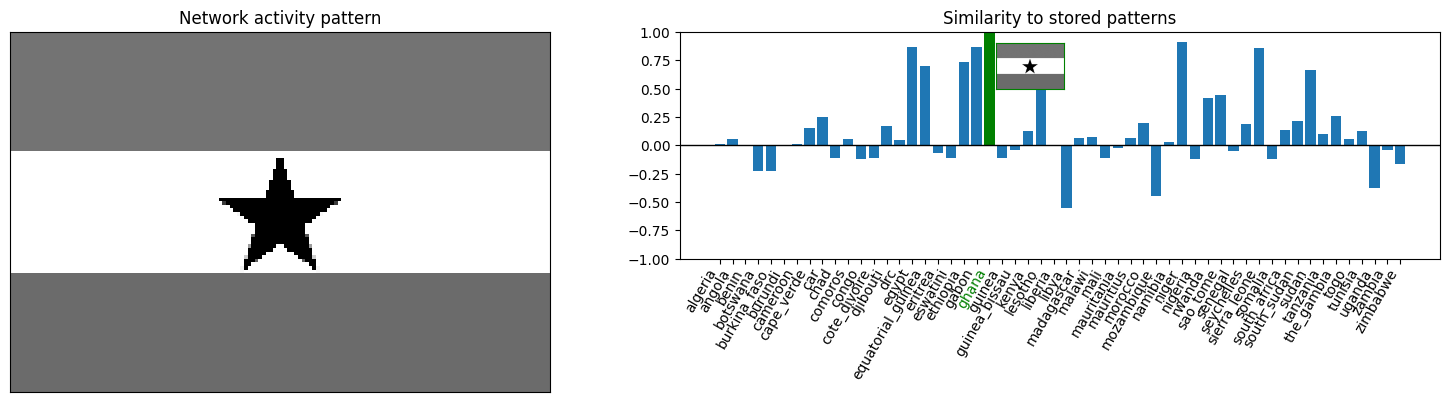

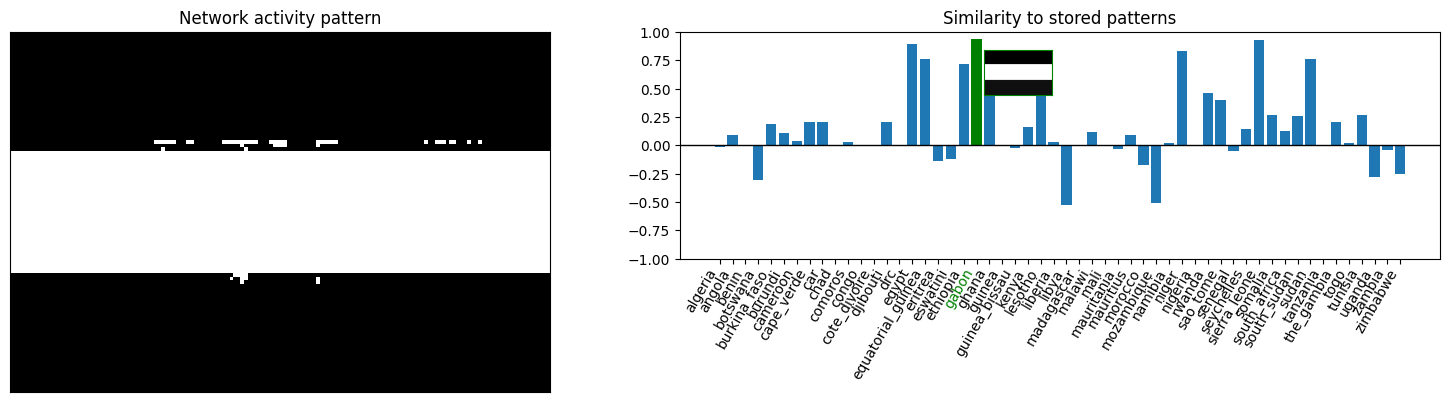

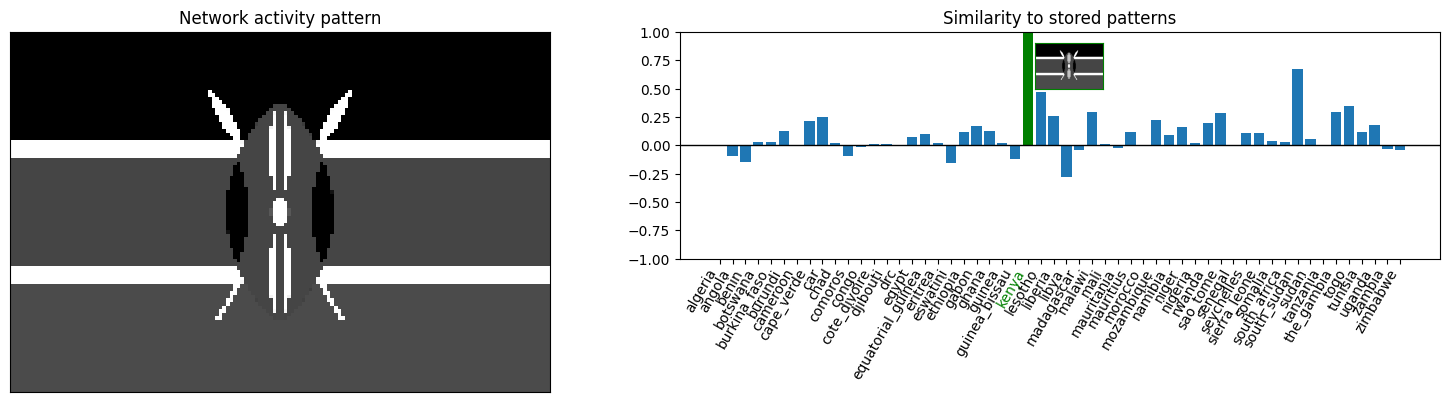

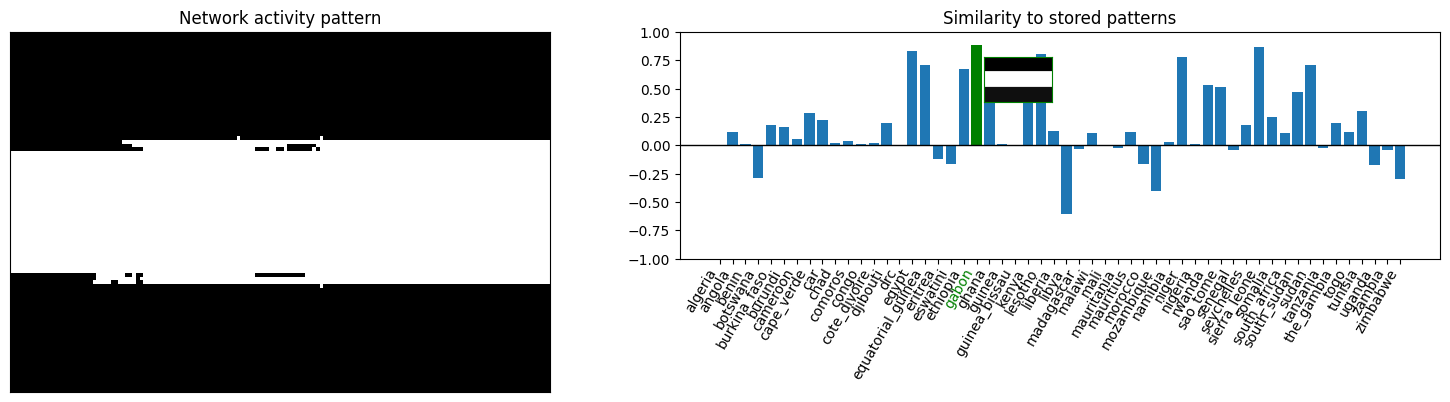

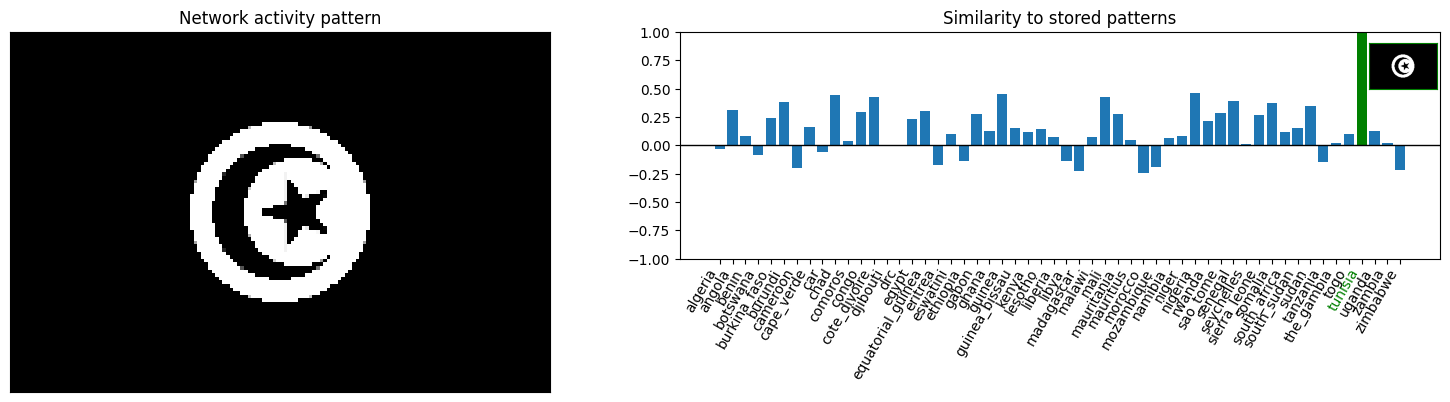

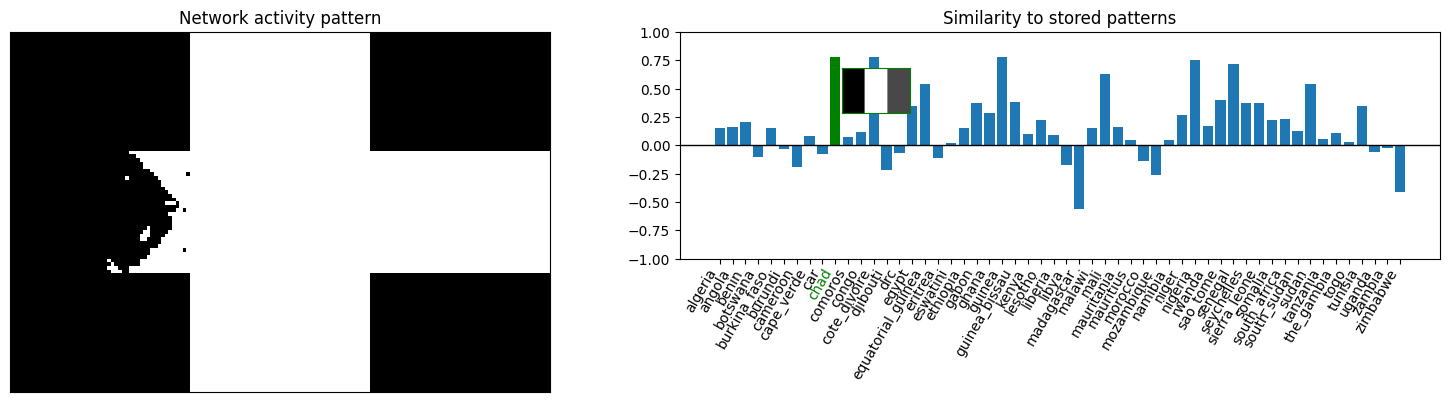

In [40]:
country = 'ghana'
HFN_complex.set_state(flags[country].flatten()) #reinitialise the state of the network
HFN_complex.visualise()
for i in tqdm(range(10)):
    HFN_complex.update_state(asynchronous=False)
HFN_complex.visualise()

country = 'kenya'
HFN_complex.set_state(flags[country].flatten()) #reinitialise the state of the network
HFN_complex.visualise()
for i in tqdm(range(10)):
    HFN_complex.update_state(asynchronous=False)
HFN_complex.visualise()

country = 'tunisia'
HFN_complex.set_state(flags[country].flatten()) #reinitialise the state of the network
HFN_complex.visualise()
for i in tqdm(range(10)):
    HFN_complex.update_state(asynchronous=False)
HFN_complex.visualise()

#### Hmmmmm...not great. :(

Here's a few ideas for why the network might not perform very well at learning African flags:

* There's **too many** flags...we've exceeded the memory capacity of the network
    * Probably not. Theory tells us the capacity of a Hopfield Network is $N_{\textrm{capacity}} \approx 0.138 N_{\textrm{neurons}}$. Here there is one neuron for each pixel (150 x 100 = 15,000) and this is wayyyy bigger than the number of countries. 
* The flags **aren't binary** (+1, -1) patterns.
    * This definitely doesn't help but the problems are more fundamental: patterns get corrupted, not just binarised. 
* The flags are **too correlated**
    * This is probably it! Classical Hopfield Network theory only holds for _uncorrelated random_ patterns. But flags are very correlated (i.e. greyscale Cote d'Ivore ~ Guinea) and not random (all contain a lot of structure e.g. strips, stars etc. )



## 4.0 Modern Hopfield Networks

I turns out its possible to improve the performance of Hopfield networks. 

_Modern Hopfield Networks_ 


This class inherits from our original `HopfieldNetwork` class so we can use all the same plotting functions etc. 

In [100]:
class ModernHopfieldNetwork(HopfieldNetwork):
    def __init__(self,patterns):
        super().__init__(patterns)
    
    def update_state(self):
        
        """This is the ONLY difference between ModernHopfieldNetwork and HopfieldNetwork. Igt has a slightly different update rule.
        Note the use of a softmax function to make the network dynamics more continuous"""

        self.state += 0.1 * (self.flattened_patterns.T @  softmax(self.flattened_patterns @ self.state) - self.state)
        self.similarities= self.get_similarities()
        self.save_history()
        
def softmax(x,b=100):
    return np.exp(x/b)/np.sum(np.exp(x/b))

In [101]:
MHFN = ModernHopfieldNetwork(flags)

In [102]:
country = 'south_africa'
MHFN.set_state(mask_pattern(flags[country]).flatten()) #reinitialise the state of the network
for i in range(20):
    MHFN.update_state()
MHFN.animate(n_steps=20)

In [105]:
for i in range(10):
    if i%2 == 0: #random seed 
        MHFN.set_state(np.random.normal(size=(MHFN.N_neurons,)))
    else:
        country = np.random.choice(list(flags.keys()))
        MHFN.set_state(mask_pattern(flags[country]).flatten())
    for i in range(20):
        MHFN.update_state()

In [107]:
anim = MHFN.animate(n_steps=200)

In [108]:
anim.save("./figures/flag_HPN.gif")